# Catching close encounters and escaping planets using exceptions
Sometimes one is interested in catching a close encounter between two planets or planets escaping the planetary system. This can be easily done with REBOUND. What you do when a close encounter or an escape happens, is up to you.

Some integrators are better suited to simulate close encounters than other. For example, the non-symplectic integrator IAS15 has an adaptive timestep scheme that resolves close encounters very well. Integrators that use a fixed timestep WHFast are more likely to miss close encounters.

In this tutorial we'll start with a two-planet system that will go unstable on a short timescale:

In [49]:
import rebound
import numpy as np
def setupSimulation():
    rebound.reset()
    rebound.set_integrator("ias15") # IAS15 is the default integrator, so we don't need this line
    rebound.add(m=1.)
    rebound.add(m=1e-3,a=1.)
    rebound.add(m=1e-3,a=1.25)
    rebound.move_to_com()

Let's integrate this system for 100 orbital periods.

In [50]:
setupSimulation()
rebound.integrate(100.*2.*np.pi)

Rebound exits the integration routine normally. We can now explore the final particle orbits:

In [51]:
for o in rebound.get_orbits():
    print(o)

<rebound.Orbit instance, a=1.33742395125 e=0.112141220571>
<rebound.Orbit instance, a=0.94351430953 e=0.0704549262265>


We see that the orbits of both planets changed significantly and we can already speculate that there was a close encounter.

Let's redo the simulation, but this time set the `minD` flag in the integrate routine. If this flag is set, then REBOUND calculates the minimum distance between any two particle pairs. If the distance is less than `minD`, then the integration is stopped and an exception thrown. The [Hill radius](http://en.wikipedia.org/wiki/Hill_sphere) is given by $r_{\rm Hill} \approx a \sqrt{\frac{m}{3M}}$ which is approximately 0.06 in our case. Let's set the breakout flag `minD` to roughly three Hill radii and see what happens:

In [52]:
setupSimulation() # Resets everything
rebound.integrate(100.*2.*np.pi, minD=0.2)

CloseEncounter: At least one particle pair has a distance < minD.

As you see, we got an exception! Let's redo the simulation once again and store the particle distance while we're integrating. We're catching the exception with a try/except construct so that out script doesn't break.

In [53]:
setupSimulation() # Resets everything
Noutputs = 1000
times = np.linspace(0,100.*2.*np.pi,Noutputs)
distances = np.zeros(Noutputs)
p = rebound.get_particles()
try:
    for i,time in enumerate(times):
        rebound.integrate(time,minD=0.2)
        dx = p[1].x - p[2].x
        dy = p[1].y - p[2].y
        dz = p[1].z - p[2].z
        distances[i] = np.sqrt(dx*dx+dy*dy+dz*dz)
except rebound.CloseEncounter:
    print("Close encounter detected at t=%f" % rebound.get_t())
    

Close encounter detected at t=67.549399


Let plot the distance as a function of time.

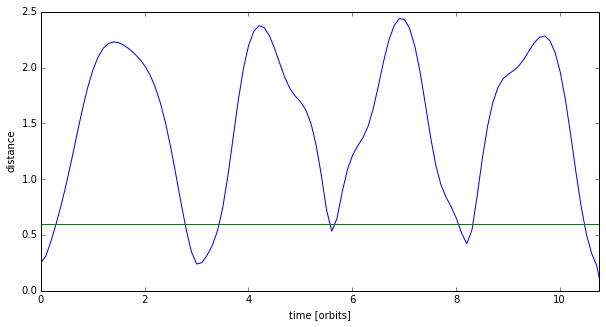

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlabel("time [orbits]")
ax.set_xlim([0,rebound.get_t()/(2.*np.pi)])
ax.set_ylabel("distance")
plt.plot(times/(2.*np.pi), distances);
plt.plot([0.0,12],[0.6,0.6]);